# Optimization with Diagram Distances

**IDEA**: Let PD(X) be the persistence diagrams on a data set X. 
We will do optimization on a different dataset $Y$ to decrease dist(PD(X), PD(Y)), where the distance function dist() is Wasserstein or Bottleneck.

In [1]:
import time
import torch
import torch.nn as nn
import torch_tda
import numpy as np
import matplotlib.pyplot as plt
import bats
from tqdm import tqdm
import hera

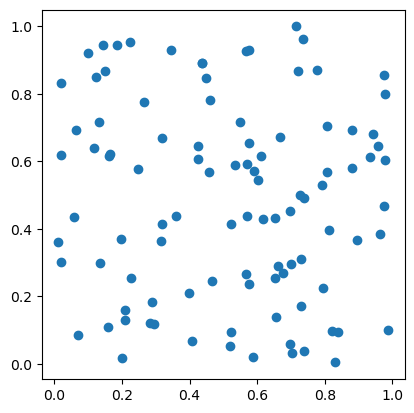

In [2]:
n = 100
np.random.seed(0)
data = np.random.uniform(0,1,(n,2))
fig1 = plt.scatter(data[:,0], data[:,1])
fig1.axes.set_aspect('equal')
X = torch.tensor(data, requires_grad=True)

In [3]:
# Compute H1 and H0
# maximum homology dimension is 1, which implies C_2 needed
# flags = (bats.standard_reduction_flag(), bats.compute_basis_flag())
flags = (bats.standard_reduction_flag(),bats.compression_flag())
# flags = ()
layer = torch_tda.nn.RipsLayer(maxdim = 1, reduction_flags=flags) 
# dgms = layer(X) # run FlagDiagram.forward()

In [4]:
dgm0 = layer(X)

In [5]:
dgm0[1][0] # the finite length persistence pairs of dim 1

tensor([[0.0375, 0.0375],
        [0.0400, 0.0400],
        [0.0443, 0.0443],
        ...,
        [0.6572, 0.6572],
        [0.6575, 0.6575],
        [0.6577, 0.6577]], dtype=torch.float64, grad_fn=<CopyBackwards>)

**Output Format of Persistent Diagram**

Inspired by Gudhi, we adopt the ouput pattern that divides essential and regular persistence pairs apart. 

Output: list (length 4) of persistence diagrams in each dimension. We separate them by dimension 
and regular/essential, which are 0-dim regular pairs, 1-dim regular pairs, 
0-dim essential pair(only one in the case Rips) and so

Return type of `layer(X)` is : List of 
- tensor[float] of shape (n-1,2), where n is the number of points 
- List[tensor[float] of shape (m,2)]
- tensor[float] of shape (1,1) 
- List[tensor[float] of shape (k,)]

In [6]:
f1 = torch_tda.nn.BarcodePolyFeature(2,0)

we'll produce a perturbed data set

In [7]:
# take a few gradient descent steps
optimizer = torch.optim.Adam([X], lr=1e-2)
for i in tqdm(range(2)):
    optimizer.zero_grad()
    dgms = layer(X)[1][0]
    loss = -f1(dgms) 
    loss.backward()
    optimizer.step()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.89it/s]


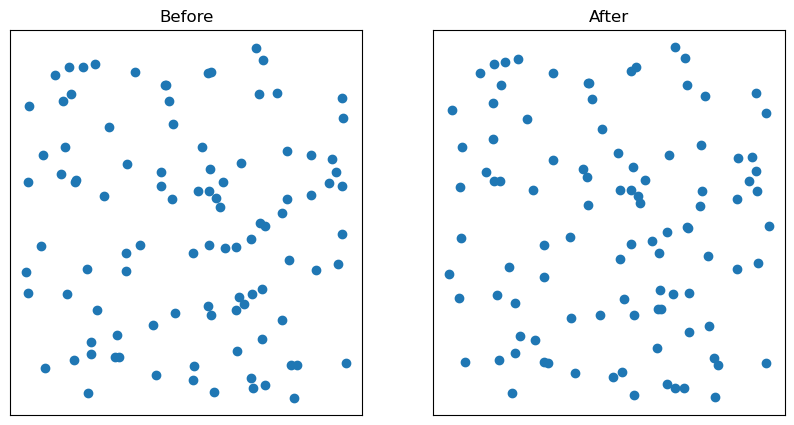

In [8]:
y = X.detach().numpy()
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title("Before")
ax[1].scatter(y[:,0], y[:,1])
ax[1].set_title("After")
for i in range(2):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(bottom=False, left=False)
plt.show()

Now, let's try to decrease a diagram distance between the two diagrams.

You can use `torch_tda.nn.WassersteinLayer()`

In [9]:
def remove_zero_bars(dgm):
    """
    remove zero bars from diagram
    """
    inds = dgm[:,0] != dgm[:,1]
    return dgm[inds,:], dgm[~inds,:]


def bott_dist(in_dgm1, in_dgm2, zero_out = False):
    # compute bottleneck distance
    if not zero_out:
        dgm1, zero_dgm1 = remove_zero_bars(in_dgm1)
        dgm2, zero_dgm2 = remove_zero_bars(in_dgm2)


    d1 = dgm1.detach().numpy()
    d2 = dgm2.detach().numpy()
    # find the bottleneck distance and the maixmum edge (two points in R^2)
    dist, edge = hera.bottleneck_dist(d1, d2, return_bottleneck_edge=True)
    return dist

In [10]:
import time

DB = torch_tda.nn.WassersteinLayer()
dgm01cpy = dgm0[1][0].detach()
bot_dist = []
# take a few gradient descent steps
optimizer = torch.optim.Adam([X], lr=1e-4)
losses = []
tph = [] # time to compute persistent homology
tdb = []
for i in tqdm(range(100)):
    optimizer.zero_grad()
    t0 = time.monotonic()
    dgms = layer(X)
    t1 = time.monotonic()
    tph.append(t1 - t0)
    
    dgms0 = dgms[1][0]
    t0 = time.monotonic()
    loss = DB(dgms0, dgm01cpy) # compute Wasserstein distances btw 2 diagrams
    bot_dist.append(bott_dist(dgms0, dgm01cpy))
    t1 = time.monotonic()
    tdb.append(t1 - t0)
    
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    
np.mean(tph), np.mean(tdb)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.08it/s]


(0.1917883182800233, 0.0027503665100039143)

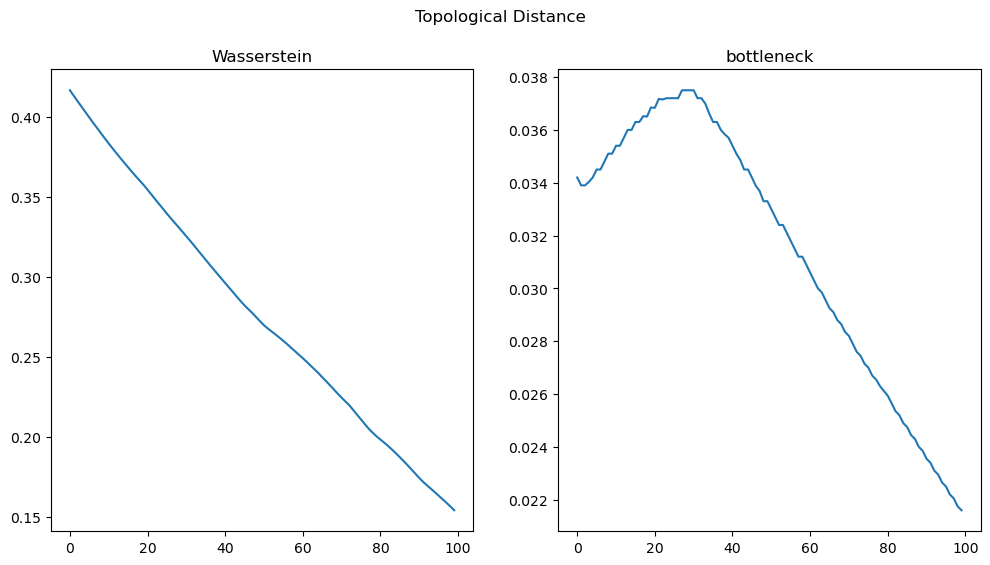

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                    figsize=(12, 6))

ax0.set_title('Wasserstein')
ax0.plot(losses)
ax1.set_title('bottleneck')
ax1.plot(bot_dist)
fig.suptitle('Topological Distance')
plt.show()

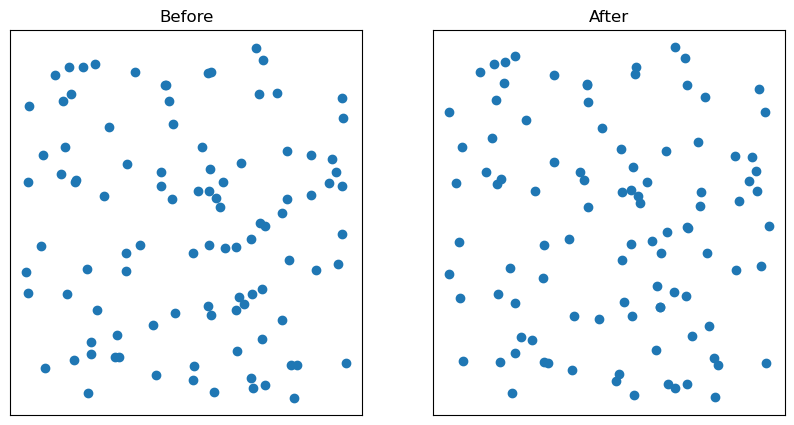

In [12]:
y = X.detach().numpy()
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].scatter(data[:,0], data[:,1])
ax[0].set_title("Before")

ax[1].scatter(y[:,0], y[:,1])
ax[1].set_title("After")

for i in range(2):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(bottom=False, left=False)

plt.show()